In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Histopathologic Cancer Detection: Kaggle Competition
 
## Overview
 
This project involves participating in the Kaggle competition titled "Histopathologic Cancer Detection." The challenge is a binary image classification problem where the goal is to identify metastatic cancer in small image patches taken from larger digital histopathology scans. This requires building a model capable of distinguishing between image patches that contain cancerous tissue and those that do not.
 
## Challenge Problem
 
Detecting cancer in pathology images is a critical task for accurate diagnosis and treatment planning. The challenge is complex due to the variability in tissue appearance, the presence of artifacts, and the need for high precision given the small size of the image patches. Participants are required to develop models that can effectively classify the images with high accuracy.
 
## Dataset Description
 
- **Size**: The dataset is large and contains tens of thousands of high-resolution images.
- **Dimensions**: Each image patch is typically 96x96 pixels.
- **Structure**: The dataset comprises two main components:
  - **Train Set**: Includes labeled images that can be used to train the model.
  - **Test Set**: Includes unlabeled images on which the model performance will be evaluated.
 
### Dataset Details
 
1. **Train Set**:
   - Each image in this set is labeled as either containing cancerous tissue (`1`) or not (`0`).
   - The total number of training images may vary, but it typically includes a substantial number of samples to ensure diverse training.
 
2. **Test Set**:
   - These images are not labeled, and you will need to predict the presence of cancerous tissue.
   - The test set is used to assess the performance of the predictive model.
 
The images are stored in a directory structure with filenames usually corresponding to unique identifiers. Efficient data handling and preprocessing are critical due to the dataset's size and the high resolution of the images.
 
## Goal
 
The primary goal of this competition is to build a model that can accurately predict whether a given image patch contains metastatic cancer. Successful models must handle the nuances of histopathology data and achieve a high level of performance in binary classification.
 
## Evaluation
 
The performance of models is evaluated using metrics such as AUC (Area Under the ROC Curve), reflecting the ability to distinguish between the two classes across the entire range of possible threshold settings.
 
By participating in this competition, we can contribute to advancements in medical image analysis and potentially influence future diagnostic methodologies.

In [2]:
# Imports
import pathlib as pl
import PIL
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import seaborn as sns
import math
import pandas as pd
from typing import List, Optional, Tuple, Dict

import time
import tensorflow as tf
from tensorflow import keras 
import keras_tuner
from keras import Sequential, Input, layers, optimizers, losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

2025-08-29 03:08:24.776071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756436905.006442      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756436905.071210      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. Exploratory Data Analysis (EDA)

Inspect, Visualize and Clean the Data

### Initial Data Assessment

In [3]:
data = pl.Path('/kaggle/input/histopathologic-cancer-detection')
test = data/'test'
train = data/'train'
train_labels = data/'train_labels.csv'

In [4]:
labels_df = pd.read_csv(train_labels)
test_list = list(test.glob('*.tif'))
test_df = pd.DataFrame({'paths': test_list})
assert len(labels_df) == 220025
assert len(test_df) == 57458

In [5]:
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
# Basic statistics of the labels dataframe
labels_df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


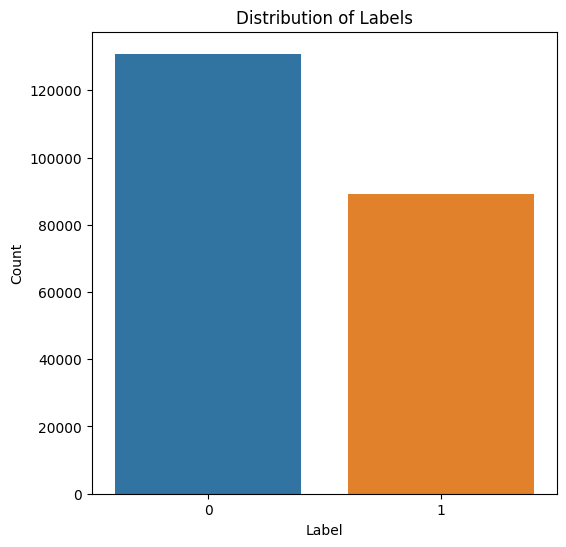

In [7]:
# Histogram of labels
plt.figure(figsize=(6, 6))
sns.countplot(x='label', data=labels_df)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

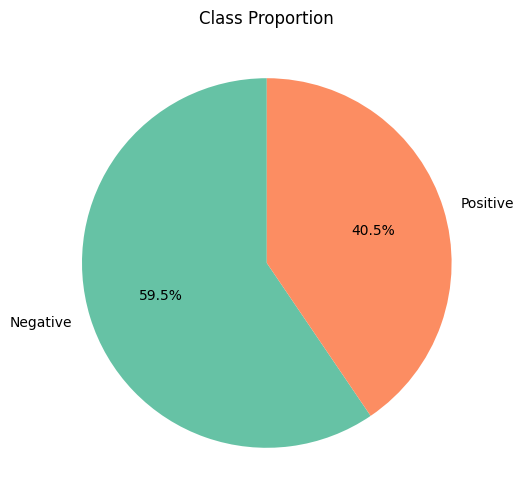

In [8]:
# Pie chart for class distribution
plt.figure(figsize=(6, 6))
labels_counts = labels_df['label'].value_counts()
plt.pie(labels_counts, labels=['Negative', 'Positive'], autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title('Class Proportion')
plt.show()

In [9]:
def gen_train_paths(row):
    file = row.id + '.tif'
    path = train/file
    #check that all of the training images exist (slow)
    #assert path.exists()
    return path
labels_df['paths'] = labels_df.progress_apply(gen_train_paths, axis = 1)

100%|██████████| 220025/220025 [00:03<00:00, 68792.47it/s]


In [10]:
def visualize_histopathology_samples(
    data_df: pd.DataFrame,
    n: int,
    figsize_per_image: Tuple[float, float] = (3, 3.5),
    max_cols: int = 5,
    title: str = "Histopathologic Image Samples",
    save_path: Optional[Path] = None,
    dpi: int = 100,
    random_state: Optional[int] = None
) -> plt.Figure:    
    # Validate required columns
    required_columns = {'id', 'label', 'paths'}
    if not required_columns.issubset(data_df.columns):
        missing = required_columns - set(data_df.columns)
        raise ValueError(f"Missing required columns: {missing}")
    
    # Sample n rows from the dataframe
    if len(data_df) <= n:
        sample_df = data_df.copy()
    else:
        sample_df = data_df.sample(n=n, random_state=random_state)
    
    # Convert paths column to Path objects if needed
    sample_df['paths'] = sample_df['paths'].apply(lambda x: Path(x) if not isinstance(x, Path) else x)
    
    # Calculate grid dimensions
    n_images = len(sample_df)
    n_cols = min(n_images, max_cols)
    n_rows = math.ceil(n_images / n_cols)
    
    # Create figure with calculated size
    fig_width = n_cols * figsize_per_image[0]
    fig_height = n_rows * figsize_per_image[1]
    fig = plt.figure(figsize=(fig_width, fig_height))
    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    
    # Create grid specification for better spacing control
    gs = fig.add_gridspec(n_rows, n_cols, hspace=0.3, wspace=0.2, 
                         top=0.94, bottom=0.02, left=0.02, right=0.98)
    
    # Process and display each image
    for idx, (_, row) in enumerate(sample_df.iterrows()):
        grid_row = idx // n_cols
        grid_col = idx % n_cols
        ax = fig.add_subplot(gs[grid_row, grid_col])
        
        try:
            # Load and display image
            img = Image.open(row['paths'])
            img_array = np.array(img)
            
            # Verify expected image format
            if img_array.shape != (96, 96, 3):
                print(f"Warning: Image {row['id']} has unexpected shape {img_array.shape}")
            
            ax.imshow(img_array)
            
            # Get label information from DataFrame row
            image_id = row['id']
            label = row['label']
            
            # Format label text with appropriate color
            if label == 1:
                label_text = "Positive (Cancer)"
                label_color = 'darkred'
            elif label == 0:
                label_text = "Negative (Normal)"
                label_color = 'darkgreen'
            else:
                label_text = "Unknown Label"
                label_color = 'gray'
            
            # Set title with class label
            ax.set_title(f"{label_text}\n{image_id}", 
                        fontsize=10, pad=5, color=label_color)
            
            # Remove axis ticks for cleaner appearance
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Add subtle border
            for spine in ax.spines.values():
                spine.set_edgecolor('gray')
                spine.set_linewidth(0.5)
                
        except Exception as e:
            # Handle loading errors gracefully
            ax.text(0.5, 0.5, f"Error loading\n{row['id']}\n{str(e)}", 
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=9, color='red', wrap=True)
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Remove any empty subplots
    for idx in range(n_images, n_rows * n_cols):
        grid_row = idx // n_cols
        grid_col = idx % n_cols
        ax = fig.add_subplot(gs[grid_row, grid_col])
        ax.set_visible(False)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Save figure if path provided
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"Figure saved to: {save_path}")
    
    # Close the figure to prevent duplicate display
    plt.close(fig)
    
    return fig

/tmp/ipykernel_36/1289536043.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


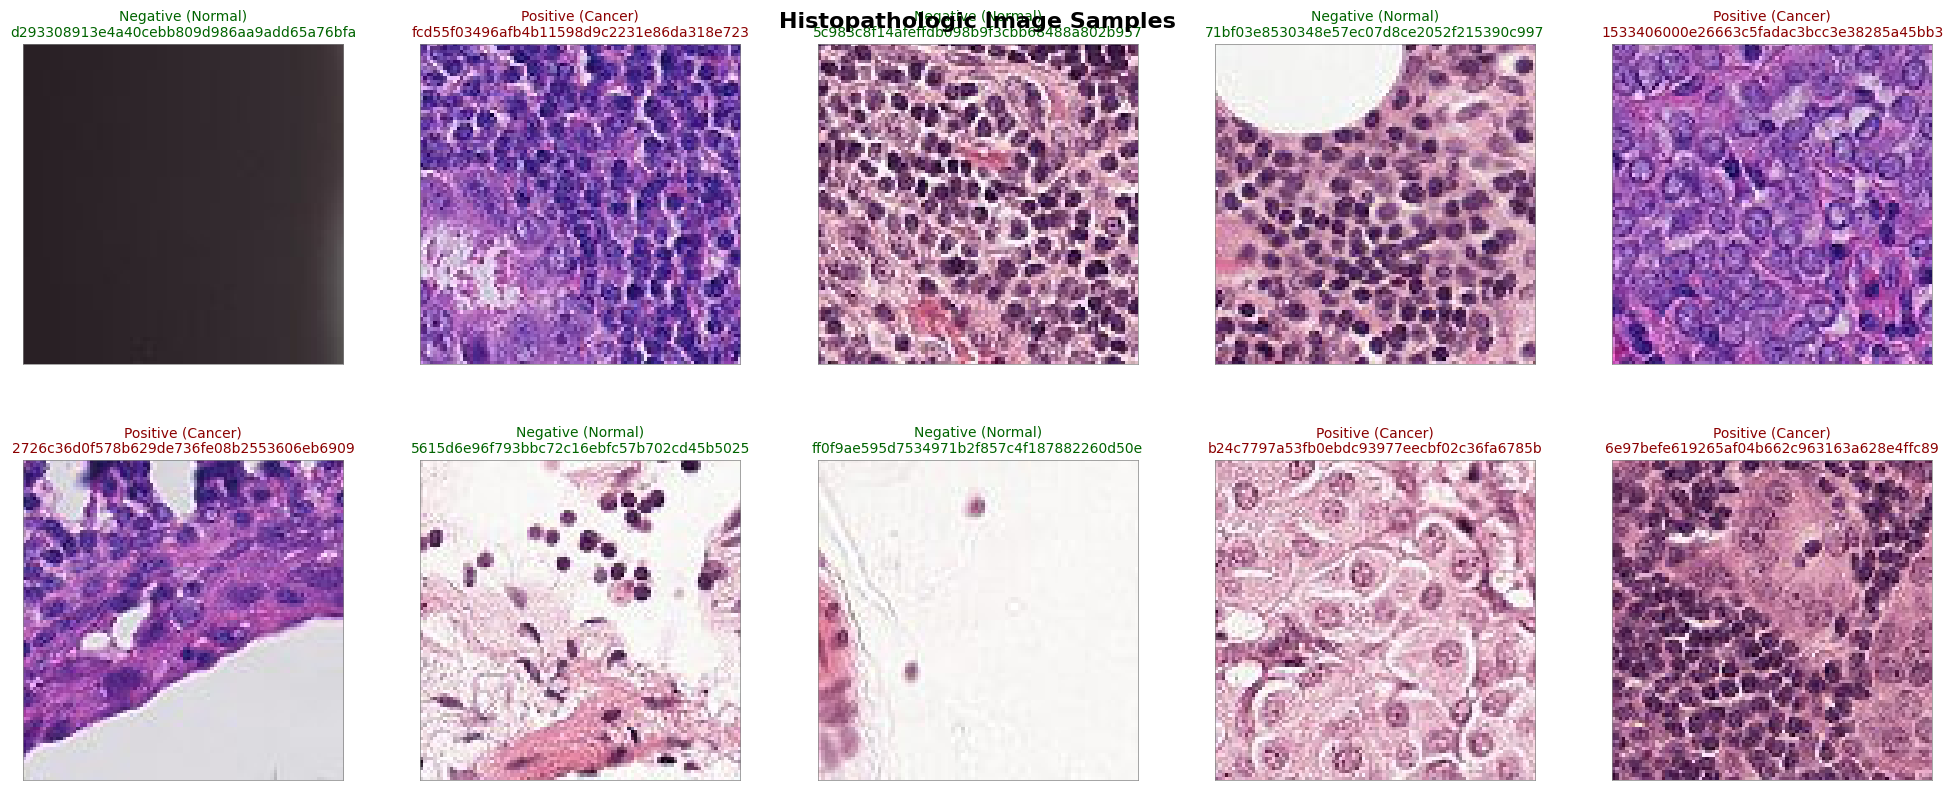

In [11]:
visualize_histopathology_samples(
    data_df = labels_df,
    n = 10,
    figsize_per_image = (4,4),
    max_cols = 5,
    title = "Histopathologic Image Samples",
    save_path = None,
    dpi = 100,
    random_state = 42
)

In [12]:
def analyze_pixel_distributions(data_df, n_samples=5000, random_state=42):
    """
    Analyze pixel intensity distributions across classes and color channels.
    
    Parameters:
    - data_df: DataFrame with 'paths' and 'label' columns
    - n_samples: Number of images to analyze (default 5000 for efficiency)
    - random_state: Random seed for reproducible sampling
    
    Returns:
    - Dictionary containing computed statistics and data for visualization
    """
    import numpy as np
    from PIL import Image
    from tqdm import tqdm
    import warnings
    warnings.filterwarnings('ignore')
    
    # Sample data for efficiency
    sample_df = data_df.sample(n=min(n_samples, len(data_df)), random_state=random_state)
    
    # Initialize storage for pixel values by class and channel
    pixel_data = {
        0: {'R': [], 'G': [], 'B': [], 'gray': []},
        1: {'R': [], 'G': [], 'B': [], 'gray': []}
    }
    
    # Collect pixel intensities
    for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), 
                      desc="Analyzing pixel intensities"):
        try:
            img = Image.open(row['paths'])
            img_array = np.array(img)
            
            # Extract each channel
            pixel_data[row['label']]['R'].extend(img_array[:,:,0].flatten())
            pixel_data[row['label']]['G'].extend(img_array[:,:,1].flatten())
            pixel_data[row['label']]['B'].extend(img_array[:,:,2].flatten())
            
            # Calculate grayscale for overall intensity
            gray = np.mean(img_array, axis=2)
            pixel_data[row['label']]['gray'].extend(gray.flatten())
            
        except Exception as e:
            print(f"Error processing {row['id']}: {e}")
    
    # Compute statistics
    statistics = {}
    for label in [0, 1]:
        statistics[label] = {}
        for channel in ['R', 'G', 'B', 'gray']:
            channel_data = np.array(pixel_data[label][channel])
            statistics[label][channel] = {
                'mean': np.mean(channel_data),
                'std': np.std(channel_data),
                'median': np.median(channel_data),
                'q1': np.percentile(channel_data, 25),
                'q3': np.percentile(channel_data, 75)
            }
    
    return pixel_data, statistics
pixel_data, stats = analyze_pixel_distributions(labels_df, n_samples=5000, random_state=42)

Analyzing pixel intensities: 100%|██████████| 5000/5000 [01:23<00:00, 59.78it/s]


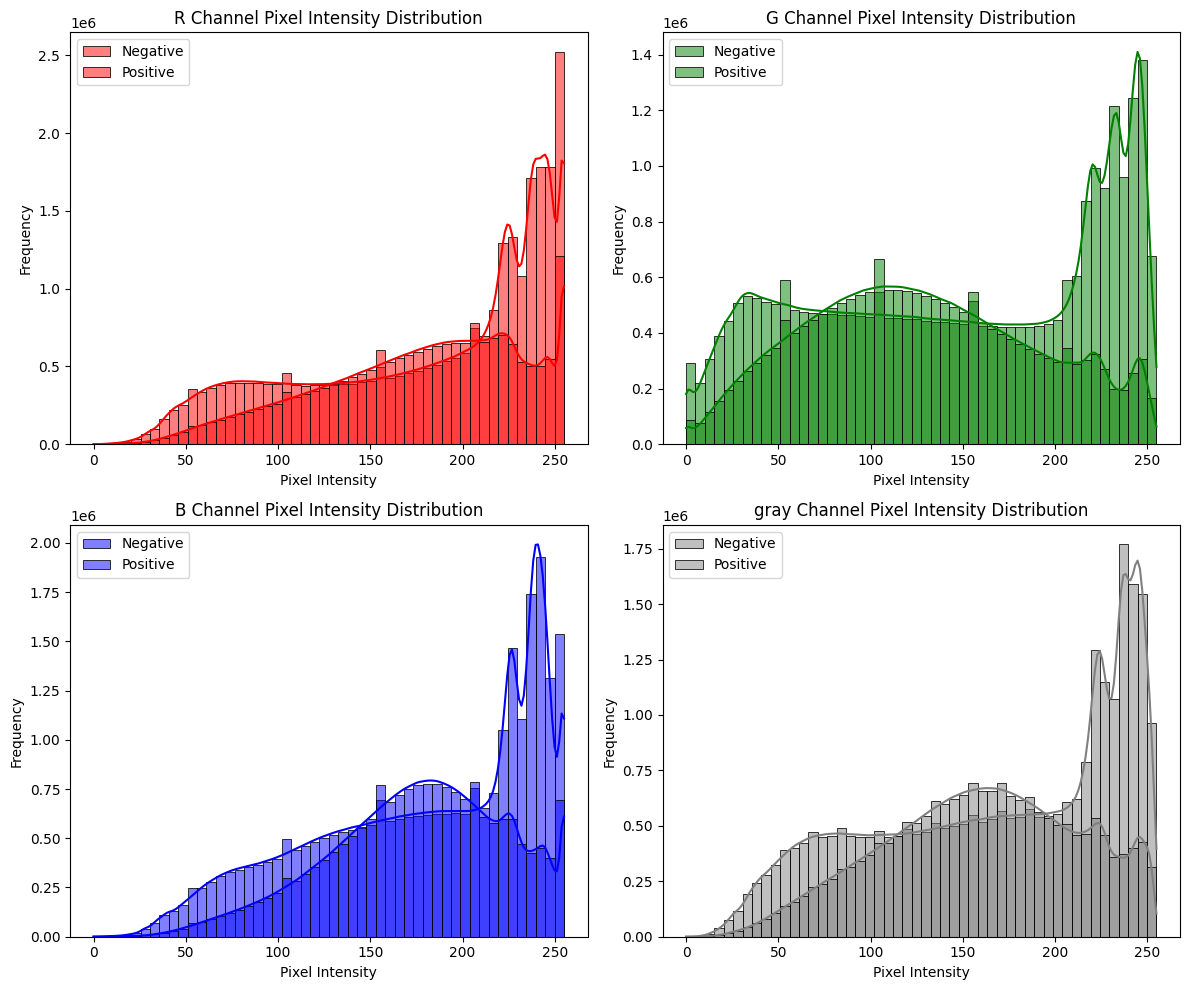

In [13]:
def plot_pixel_intensity_distributions(pixel_data):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    color_map = ['red', 'green', 'blue', 'gray']
 
    for idx, channel in enumerate(['R', 'G', 'B', 'gray']):
        ax = axes.flatten()[idx]
        for label, label_name in [(0, 'Negative'), (1, 'Positive')]:
            sns.histplot(pixel_data[label][channel], bins=50, kde=True, ax=ax, color=color_map[idx], alpha=0.5, label=f'{label_name}')
        ax.set_title(f'{channel} Channel Pixel Intensity Distribution')
        ax.set_xlabel('Pixel Intensity')
        ax.set_ylabel('Frequency')
        ax.legend()
 
    plt.tight_layout()
    plt.show()
 
# Call the function to plot pixel distributions
plot_pixel_intensity_distributions(pixel_data)

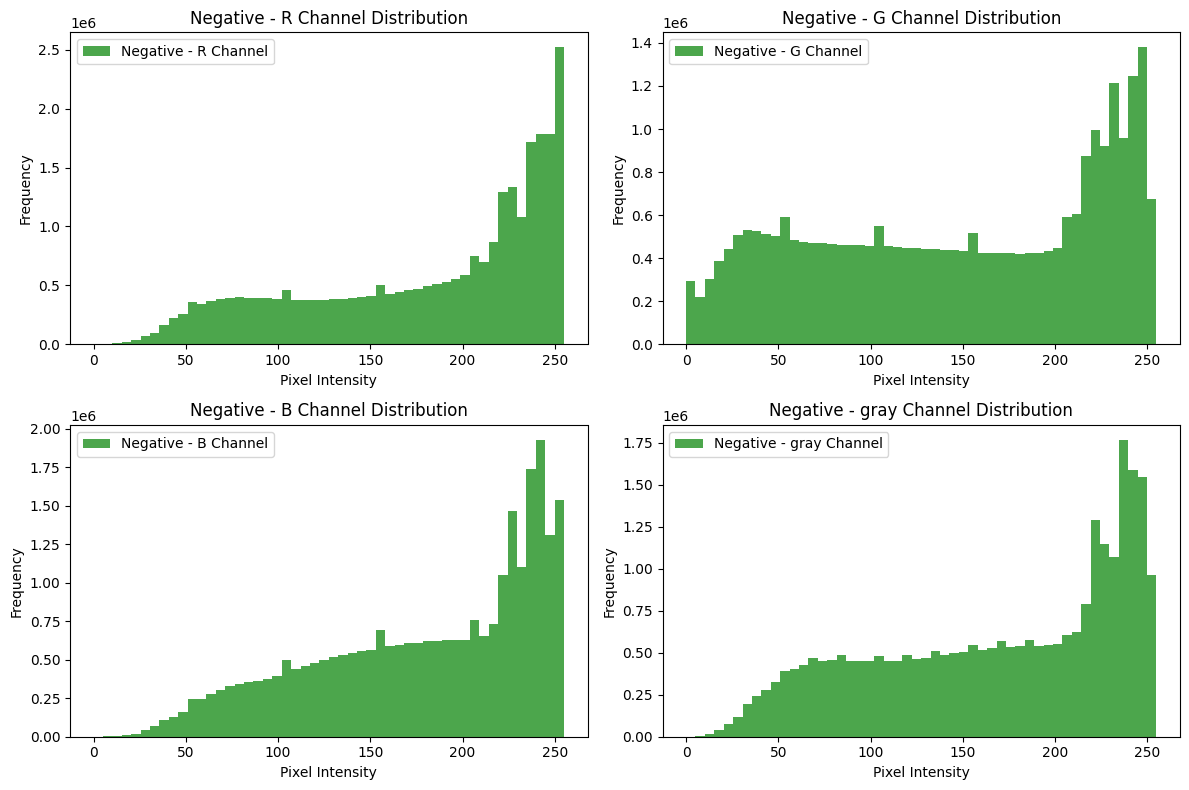

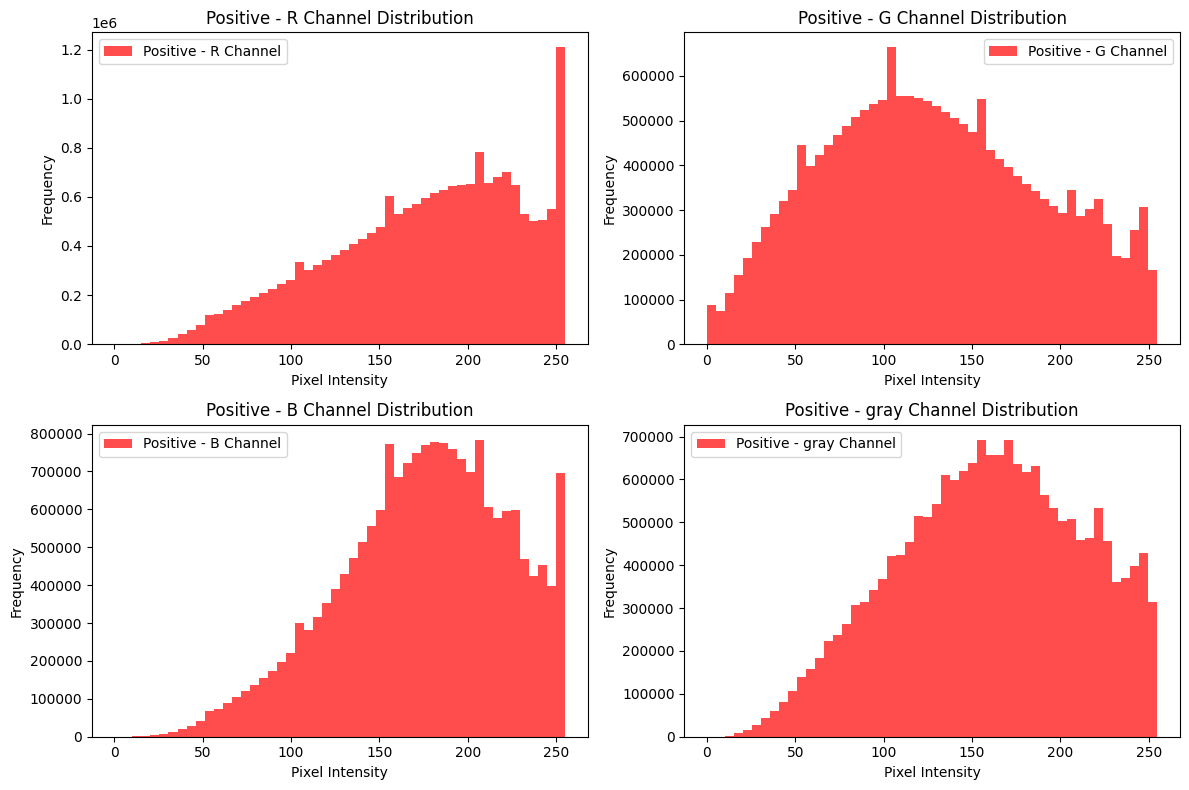

In [14]:
for label, label_name in [(0, 'Negative'), (1, 'Positive')]:
    plt.figure(figsize=(12, 8))
    for idx, (channel, color) in enumerate(pixel_data[label].items()):
        plt.subplot(2, 2, idx+1)
        plt.hist(color, bins=50, color=('red' if label else 'green'), alpha=0.7, label=f'{label_name} - {channel} Channel')
        plt.title(f'{label_name} - {channel} Channel Distribution')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Model Architecture and Hyperparameter Tuning
 
## Model Architecture
 
The model architecture chosen for histopathologic cancer detection is a Convolutional Neural Network (CNN). The design consists of multiple convolutional layers followed by dense layers, optimized for image classification tasks. Here is a breakdown of the structure:
 
1. **Convolutional Layers**: 
   - The model starts with a moderate number of filters, which progressively increase across subsequent layers. This allows the model to capture more complex patterns and features at deeper levels.
   - Batch normalization is applied after each convolutional layer to stabilize and accelerate training by normalizing input distributions.
 
2. **Max-Pooling Layers**:
   - Max-pooling is utilized after each convolutional block to down-sample the spatial dimensions, reducing the computational load and focusing the model on the most relevant features.
 
3. **Optional Third Convolutional Block**:
   - An additional convolutional block can be added based on hyperparameters to enhance feature extraction, especially for complex datasets.
 
4. **Dense Layers**:
   - The dense layer is designed with a manageable number of units to balance model capacity and computational efficiency. Dropout is applied for regularization, preventing overfitting by randomly dropping connections during training.
 
5. **Output Layer**:
   - A single neuron with a sigmoid activation function is used for binary classification to predict the likelihood of metastatic cancer in the input image.
 
## Rationale for the Model Architecture
 
- **Scalability**: The use of a CNN is appropriate for handling high-dimensional image data. CNNs are known for their ability to capture spatial hierarchies due to their shared weights architecture.
  
- **Regularization**: Batch normalization and dropout are used to improve model generalization by preventing overfitting.
 
- **Flexibility**: Hyperparameters are utilized to allow dynamic adjustment of the model's capacity, including options to add additional layers for more complex abstractions.
 
- **Efficiency**: By starting with a smaller model and progressively increasing complexity, it allows for rapid prototyping and tuning based on dataset characteristics before committing to more extensive architectures.
 
## Comparison with Other Architectures
 
- **Simpler CNNs**: A shallower model with fewer layers may not capture the complex patterns present in histopathologic images, potentially leading to underfitting.
 
- **Deeper Architectures**: More profound architectures tend to improve performance but at the cost of increased computational demand and potential overfitting without adequate regularization.
 
- **Transformers or Hybrid Models**: While innovative, these might be overkill for this particular task unless the dataset complexity or data size justifies such an architectural choice.
 
## Hyperparameter Tuning
 
- **Bayesian Optimization**: We used Bayesian Optimization with the KerasTuner library for hyperparameter search. This method is efficient and robust for exploring the hyperparameter space, optimizing for the highest validation AUC (Area Under the Curve).
 
- **Tunable Hyperparameters**: 
  - Number of filters in each convolutional layer.
  - Kernel sizes.
  - Size of the dense layer.
  - Dropout rates.
  - Learning rates.
  - Optional addition of a third convolutional block.
 
- **Early Stopping**: An early stopping criterion is implemented to halt training when the validation AUC ceases to improve, saving computational resources and preventing overfitting.
 
## Conclusion
 
This model is designed to balance complexity and efficiency, making it suitable for tasks requiring a deep understanding of image structures, such as histopathology cancer detection. This approach allows us to dynamically adjust model parameters and explore architectural variations to optimize performance on this task.

In [15]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

def build_model(hp):
    model = Sequential()

    # First Conv Block: Start with moderate filters
    model.add(Conv2D(
        filters=hp.Int('conv_1_filter', min_value=64, max_value=96, step=16),  # Narrowed range
        kernel_size=hp.Choice('conv_1_kernel', values=[3]),
        activation='relu',
        kernel_regularizer=l2(0.001),
        input_shape=(96, 96, 3)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Conv Block: Deeper features
    model.add(Conv2D(
        filters=hp.Int('conv_2_filter', min_value=64, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values=[3]),
        activation='relu',
        kernel_regularizer=l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Optional third Conv block (controlled by HP)
    if hp.Boolean('add_third_conv'):
        model.add(Conv2D(
            filters=hp.Int('conv_3_filter', min_value=128, max_value=256, step=32),
            kernel_size=3,
            activation='relu',
            kernel_regularizer=l2(0.001)
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Dense layer: Focus on efficient sizes
    dense_units = hp.Int('dense_units', min_value=128, max_value=256, step=32)
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1)))

    # Output
    model.add(Dense(1, activation='sigmoid'))

    # Use tuned learning rate
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='log')
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model


default_model = build_model(keras_tuner.HyperParameters())

In [16]:
def create_generators(data_df, validation_size=0.2, batch_size=32, random_state=42):
    data_df = data_df.copy()

    # Convert Path to string if needed
    if len(data_df) > 0 and isinstance(data_df['paths'].iloc[0], Path):
        print("Converting Path objects to strings...")
        data_df['paths'] = data_df['paths'].astype(str)

    # Convert labels to string for flow_from_dataframe
    if data_df['label'].dtype in ['int64', 'int32']:
        print("Converting integer labels to strings...")
        data_df['label'] = data_df['label'].astype(str)

    # Stratified split
    train_df, val_df = train_test_split(
        data_df,
        test_size=validation_size,
        stratify=data_df['label'],
        random_state=random_state
    )
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    print(f"\nDataset split:")
    print(f"  Total samples: {len(data_df)}")
    print(f"  Training: {len(train_df)} ({100*(1-validation_size):.0f}%)")
    print(f"  Validation: {len(val_df)} ({100*validation_size:.0f}%)")
    print(f"\nClass distribution:")
    print(f"  Training: {dict(train_df['label'].value_counts().sort_index())}")
    print(f"  Validation: {dict(val_df['label'].value_counts().sort_index())}")

    # Data augmentation (aggressive for histopathology)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        zoom_range=0.1,
        fill_mode='reflect'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='paths',
        y_col='label',
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True,
        seed=random_state,
        validate_filenames=False
    )

    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='paths',
        y_col='label',
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,
        validate_filenames=False
    )

    steps_per_epoch = len(train_df) // batch_size
    validation_steps = len(val_df) // batch_size

    print(f"\nGenerator info:")
    print(f"  Steps per epoch (train): {steps_per_epoch}")
    print(f"  Validation steps: {validation_steps}")
    print(f"  Class indices: {train_generator.class_indices}")

    return train_generator, val_generator, train_df, val_df

In [17]:
# Create generators with default 80/20 split
train_gen, val_gen, train_df, val_df = create_generators(
    data_df=labels_df, 
    validation_size=0.2,
    batch_size=128,
    random_state=42
)
# Verify generator output
batch_images, batch_labels = next(train_gen)
print(f"\nBatch verification:")
print(f"  Images shape: {batch_images.shape}")
print(f"  Labels shape: {batch_labels.shape}")
print(f"  Image value range: [{batch_images.min():.3f}, {batch_images.max():.3f}]")

Converting Path objects to strings...
Converting integer labels to strings...

Dataset split:
  Total samples: 220025
  Training: 176020 (80%)
  Validation: 44005 (20%)

Class distribution:
  Training: {'0': 104726, '1': 71294}
  Validation: {'0': 26182, '1': 17823}
Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.

Generator info:
  Steps per epoch (train): 1375
  Validation steps: 343
  Class indices: {'0': 0, '1': 1}

Batch verification:
  Images shape: (128, 96, 96, 3)
  Labels shape: (128,)
  Image value range: [0.000, 1.000]


In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_auc', 
                                         patience = 2,mode='max',
                                        restore_best_weights=True)
tuner = kt.BayesianOptimization(
        build_model,
        objective=kt.Objective("val_auc", direction="max"),  # Maximize AUC
        max_trials=2,
        directory="kt_dir",
        overwrite=True)
tuner.search_space_summary()

Search space summary
Default search space size: 8
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 96, 'step': 16, 'sampling': 'linear'}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3], 'ordered': True}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3], 'ordered': True}
add_third_conv (Boolean)
{'default': False, 'conditions': []}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [19]:
model_checkpoint = ModelCheckpoint(
        filepath=f"best_model.h5",
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1)
tuner.search(train_gen, epochs = 2,steps_per_epoch=100,
    validation_steps=10,validation_data = val_gen, callbacks=[early_stopping, model_checkpoint])

Trial 2 Complete [00h 04m 09s]
val_auc: 0.6229233145713806

Best val_auc So Far: 0.6229233145713806
Total elapsed time: 00h 08m 49s


In [20]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n Best hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"  {key}: {value}")

 Best hyperparameters:
  conv_1_filter: 96
  conv_1_kernel: 3
  conv_2_filter: 96
  conv_2_kernel: 3
  add_third_conv: True
  dense_units: 160
  dropout_rate: 0.3
  learning_rate: 0.000581295948555771
  conv_3_filter: 128


In [21]:
history = best_model.fit(train_gen, epochs = 5,validation_data = val_gen, callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8195 - auc: 0.8865 - loss: 0.6286
Epoch 1: val_auc improved from -inf to 0.78570, saving model to best_model.h5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1813s 1s/step - accuracy: 0.8195 - auc: 0.8866 - loss: 0.6286 - val_accuracy: 0.7114 - val_auc: 0.7857 - val_loss: 0.9630
Epoch 2/5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.8737 - auc: 0.9369 - loss: 0.4279
Epoch 2: val_auc improved from 0.78570 to 0.78936, saving model to best_model.h5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 903s 656ms/step - accuracy: 0.8737 - auc: 0.9369 - loss: 0.4279 - val_accuracy: 0.7264 - val_auc: 0.7894 - val_loss: 1.4390
Epoch 3/5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.8958 - auc: 0.9535 - loss: 0.3725
Epoch 3: val_auc improved from 0.78936 to 0.86695, saving model to best_model.h5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 906s 658ms/step - accuracy: 0.8958 - auc: 0.9535 - loss: 0.3724 - val_accuracy: 0.7775 - val_auc: 0.8670 - val_loss

In [22]:
# Evaluate the model on the validation set
val_loss, val_accuracy, val_auc = best_model.evaluate(val_gen, steps=len(val_gen))
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

Validation Loss: 0.4352
Validation Accuracy: 0.8661
Validation AUC: 0.9548


In [23]:
# Plot training history
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Hyperparameter Tuning and Model Performance Analysis
 
## Introduction
 
This document provides an analysis of the hyperparameter tuning conducted using Bayesian Optimization for a Convolutional Neural Network (CNN) applied to the task of histopathologic cancer detection. The optimization goal was to maximize the validation AUC (Area Under the ROC Curve).
 
## Experimental Setup
 
- **Search Space Summary**: The tuning involved multiple hyperparameters including the number of filters in the convolutional layers, kernel sizes, the inclusion of a third convolutional block, the number of dense units, dropout rates, and learning rate.
- **Optimization Method**: Bayesian Optimization was employed to efficiently explore the hyperparameter space. The objective was maximizing `val_auc`.
- **Trained Models**: The best model architecture selected during tuning had:
  - `conv_1_filter`: 96
  - `conv_2_filter`: 96
  - `add_third_conv`: True
  - `conv_3_filter`: 128
  - `dense_units`: 160
  - `dropout_rate`: 0.3
  - `learning_rate`: 0.000581
 
## Results Overview
 
The below table summarizes the results over multiple epochs for the best model:
 
| Epoch | Training Accuracy | Training AUC | Validation Accuracy | Validation AUC | Validation Loss |
|-------|-------------------|--------------|---------------------|----------------|-----------------|
| 1     | 0.8195            | 0.8866       | 0.7114              | 0.7857         | 0.9630          |
| 2     | 0.8737            | 0.9369       | 0.7264              | 0.7894         | 1.4390          |
| 3     | 0.8958            | 0.9535       | 0.7775              | 0.8670         | 0.5946          |
| 4     | 0.9045            | 0.9607       | 0.8661              | 0.9548         | 0.4352          |
| 5     | 0.9082            | 0.9617       | 0.7399              | 0.6282         | 1.4718          |
 
### Best Validation Results
 
- **Validation Loss**: 0.4352
- **Validation Accuracy**: 0.8661
- **Validation AUC**: 0.9548
 
## Analysis
 
### Success Factors
 
- **Early Success**: The validation AUC improved significantly in the initial epochs, indicating a strong model fit early in the training process.
- **Regularization**: The use of L2 regularization and dropout helped prevent overfitting, which is crucial for generalizing from complex data.
- **Data Augmentation**: Aggressive data augmentation likely contributed to increased robustness against overfitting.
 
### Challenges and Issues
 
- **Validation AUC Degradation**: Noticed in later epochs, the validation AUC dropped despite improving training metrics—indicative of overfitting.
- **Over-tuning**: Model complexity might have been slightly high, suggesting potential benefits from simpler architectures.
 
## Conclusion and Future Work
 
### Key Insights
 
- Effective integration of data augmentation and regularization strategies significantly improved model performance.
- The hyperparameter tuning process provided valuable configurations, but monitoring for overfitting remains essential.
 
### Proposed Improvements
 
1. **Explore ReduceLRonPlateau**: Implement dynamic learning rates that adjust based on validation loss plateaus to refine learning processes.
2. **Cross-Validation**: Integrate a cross-validation approach to ensure model robustness across data splits.
3. **Simplification**: Test simpler architectures to evaluate potential improvements in generalization performance.
4. **Ensemble Methods**: Consider ensemble techniques to capitalize on the strengths of multiple CNN architectures.
 
### Learned Lessons
 
- Regularization and data augmentation are potent techniques in medical imaging data contexts.
- A systematic approach to hyperparameter tuning using Bayesian Optimization significantly aids efficient exploration of the hyperparameter space. This strategic tuning can optimize model capacity without excessive computational costs.
 
These insights and potential improvements outline a roadmap for subsequent experiments and iterative enhancements to systematically address current architecture challenges.

In [24]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Set the path to the test directory
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'

# Load test images
test_images = []
test_ids = []

for filename in os.listdir(test_dir):
    if filename.endswith(".tif"):
        img_path = os.path.join(test_dir, filename)
        img = load_img(img_path, target_size=(96, 96))  # Adjust target_size based on your model input size
        img_array = img_to_array(img)
        test_images.append(img_array)
        test_ids.append(filename.split('.')[0])

# Convert to numpy array
test_images = np.array(test_images)

# Normalize images if your model requires it (optional)
test_images = test_images / 255.0

# Load your trained model
model = best_model

# Generate predictions
y_pred = model.predict(test_images)
y_pred = (y_pred > 0.5).astype(int).reshape(-1)  # Convert to binary labels if necessary

# Create a DataFrame
submission_df = pd.DataFrame({
    'id': test_ids,
    'label': y_pred
})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully!")